# Modelagem da variação da temperatura de um PSMS

## Introdução

Os motores síncronos a ímãs permanentes (Permanent Magnet Synchronous Motor - PMSM) alimentados por inversor de freqüência podem são uma opção apropriada em várias aplicações na indústria devido ao seu alto torque e alto desempenho.
Os PMSMs possuem tamanho e volume reduzidos e podem funcionar em uma ampla faixa de velocidades.


![](https://alliedmarketresearch.files.wordpress.com/2017/02/permanent-magnet-synchronous-motor-pmsm.png?w=705)

Porém, alguns componentes sensíveis à temperatura são vulneráveis à falha sob estresse termal e precisam ser monitorados.

Um superaquecimento no estator pode fazê-lo derreter e, caso atinja os imãs permanentes, pode faze-los desmagnetizarem irreversivelmente.


![](https://images.squarespace-cdn.com/content/v1/56c20776f699bbc849dc0a69/1458920344064-XRVKU3O788XYJNS0TQ3A/ke17ZwdGBToddI8pDm48kH6fpDepVnHDbJBHVrcFH3VZw-zPPgdn4jUwVcJE1ZvWQUxwkmyExglNqGp0IvTJZamWLI2zvYWH8K3-s_4yszcp2ryTI0HqTOaaUohrI8PICKwaTIMLhQJ9fACjqaf26fF01mQeTIdmmTPu11VCbBkKMshLAGzx4R3EDFOm1kBS/image-asset.jpeg?format=500w)


Hoje em dia, os pontos quentes do estator são monitorados com sensores térmicos, que são embutidos e não podem ser substituídos. O problema é que perdem funcionalidade com o tempo.
Outro problema é que não é possível aplicar sensores térmicos no rotor devido à sua rotação e estrutura complexa. Caso fossem adicionados, aumentaria muito os custos de produção.

Então, o que se faz atualmente é adicionar uma margem de segurança em material no motor pra evitar o superaquecimento.
Como consequência, o potencial de sobrecarga de um PSMS nunca é totalmente utilizado. 
Este problema, junto com a pressão de custo constante no setor automotivo, conduz a investigação de métodos de estimativa de temperatura em tempo real suficientemente precisos.



## O teste

Foi utilizado um protótipo de motor PMSM de uma fabricante alemã com o nome não divulgado. As medições foram realizadas em laboratório numa bancada na Paderborn University.

![](https://scontent.fccm1-1.fna.fbcdn.net/v/t1.6435-9/203342690_4033096946759776_927109283836097485_n.jpg?_nc_cat=102&ccb=1-3&_nc_sid=730e14&_nc_ohc=gxuqQUs4cLsAX9AYRos&_nc_ht=scontent.fccm1-1.fna&oh=1bf31495419c43fa1fd2b080e4df5231&oe=60E0E991)

Para realização do teste, o motor foi excitado por ciclos de direção, denotando uma velocidade de motor de referência e um torque de referência. 

As correntes em coordenadas d-q e tensões nas coordenadas d-q são o resultado de uma estratégia de controle padrão tentando seguir a velocidade de referência e o torque. As colunas “motor_speed” e “torque” são as grandezas resultantes alcançadas por essa estratégia, derivadas das correntes e tensões definidas. A maioria dos ciclos de direção denotam caminhadas aleatórias no plano de velocidade-torque a fim de imitar os ciclos de direção do mundo real em um grau mais preciso do que as constantes subidas, acelerações e descidas. (Kirchgässner, W., Wallscheid, O. e Böcker, J., 2021)

## Variáveis mensuradas

Variáveis de entrada:
- u_d: Medição do componente d da voltagem em coordenadas-dq (em V);
- u_q: Medição do componente q da voltagem em coordenadas-dq (em V);
- i_d: Medição do componente d da corrente atual em coordenadas-dq;
- i_q: Medição do componente q da corrente atual em coordenadas-dq
- coolant: Temperatura do líquido de arrefecimento; 
- motor_speed: Velocidade do motor (em rpm);
- ambient: Temperatura ambiente (em ºC);

Variáveis de saída:
- pm: Temperatura do ímã permanente (em ºC) medida com termopares e transmitida de forma sem fio via uma unidade de termografia;
- stator_yoke: Temperatura da parte magnética do estator (em ºC) medida com termopares;
- stator_winding: Temperatura do enrolamento do estator (em ºC) medida com termopares;
- stator_tooth: Temperatura do dente do estator (em ºC) medida com termopares;

Variável não considerada:
- torque: Torque do motor (em Nm);


## Objetivo

Através dos dados obtidos das variáveis de entrada, encontrar meios de modelar o comportamento da temperatura do rotor.


# Importação das bibliotecas e leitura dos dados



In [1]:


import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import os
print(os.listdir("../input"))
plt.style.use('bmh')

['measures_v2.csv']


# Análise do Dataset

In [2]:
df = pd.read_csv('../input/measures_v2.csv')
target_features = ['pm', 'stator_tooth', 'stator_yoke', 'stator_winding']
df.shape

# 1.333.816 linhas (medidas tomadas)
# 13 colunas (variáveis)

(1330816, 13)

In [3]:
df.info()

#todas as variávies já estão no formato numérico
#nenhum dado nulo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


In [4]:
df

u_q    coolant  stator_winding       u_d  stator_tooth  \
0       -0.450682  18.805172       19.086670 -0.350055     18.293219   
1       -0.325737  18.818571       19.092390 -0.305803     18.294807   
2       -0.440864  18.828770       19.089380 -0.372503     18.294094   
3       -0.327026  18.835567       19.083031 -0.316199     18.292542   
4       -0.471150  18.857033       19.082525 -0.332272     18.291428   
...           ...        ...             ...       ...           ...   
1330811 -2.152128  30.721298       45.274497  0.791801     41.934347   
1330812 -2.258684  30.721306       45.239017  0.778900     41.868923   
1330813 -2.130312  30.721312       45.211576  0.804914     41.804819   
1330814 -2.268498  30.721316       45.193508  0.763091     41.762220   
1330815 -2.100158  30.721319       45.132307  0.807309     41.734763   

         motor_speed       i_d       i_q         pm  stator_yoke    ambient  \
0           0.002866  0.004419  0.000328  24.554214    18.316547  19.850691   
1           0.000257  0.000606 -0.000785  24.538078    18.314955  19.850672   
2           0.002355  0.001290  0.000386  24.544693    18.326307  19.850657   
3           0.006105  0.000026  0.002046  24.554018    18.330833  19.850647   
4           0.003133 -0.064317  0.037184  24.565397    18.326662  19.850639   
...              ...       ...       ...        ...          ...        ...   
1330811     0.000380 -2.000169  1.097528  62.147780    38.653720  23.989078   
1330812     0.002985 -2.000499  1.097569  62.142646    38.656328  23.970700   
1330813     0.002301 -1.999268  1.098765  62.138387    38.650923  23.977234   
1330814     0.005662 -2.000999  1.095696  62.133422    38.655686  24.001421   
1330815     0.004395 -2.000792  1.096487  62.131429    38.660370  24.027522   

               torque  profile_id  
0        1.871008e-01          17  
1        2.454175e-01          17  
2        1.766153e-01          17  
3        2.383027e-01          17  
4        2.081967e-01          17  
...               ...         ...  
1330811 -8.116730e-60          71  
1330812 -5.815891e-60          71  
1330813 -4.167268e-60          71  
1330814 -2.985978e-60          71  
1330815 -2.139547e-60          71  

[1330816 rows x 13 columns]

# Análise exploratória dos dados - EDA

In [5]:
df.describe()
#como interpretar: e+0x significa quantas casas pra direita a vírgula tem que andar
#ex. temperatura maxima do coolant: 1.015985e+02 significa 101.5985 graus celsius


u_q       coolant  stator_winding           u_d  stator_tooth  \
count  1.330816e+06  1.330816e+06    1.330816e+06  1.330816e+06  1.330816e+06   
mean   5.427900e+01  3.622999e+01    6.634275e+01 -2.513381e+01  5.687858e+01   
std    4.417323e+01  2.178615e+01    2.867206e+01  6.309197e+01  2.295223e+01   
min   -2.529093e+01  1.062375e+01    1.858582e+01 -1.315304e+02  1.813398e+01   
25%    1.206992e+01  1.869814e+01    4.278796e+01 -7.869090e+01  3.841601e+01   
50%    4.893818e+01  2.690014e+01    6.511013e+01 -7.429755e+00  5.603635e+01   
75%    9.003439e+01  4.985749e+01    8.814114e+01  1.470271e+00  7.558668e+01   
max    1.330370e+02  1.015985e+02    1.413629e+02  1.314698e+02  1.119464e+02   

        motor_speed           i_d           i_q            pm   stator_yoke  \
count  1.330816e+06  1.330816e+06  1.330816e+06  1.330816e+06  1.330816e+06   
mean   2.202081e+03 -6.871681e+01  3.741278e+01  5.850678e+01  4.818796e+01   
std    1.859663e+03  6.493323e+01  9.218188e+01  1.900150e+01  1.999100e+01   
min   -2.755491e+02 -2.780036e+02 -2.934268e+02  2.085696e+01  1.807669e+01   
25%    3.171107e+02 -1.154061e+02  1.095863e+00  4.315158e+01  3.199033e+01   
50%    1.999977e+03 -5.109376e+01  1.577401e+01  6.026629e+01  4.562551e+01   
75%    3.760639e+03 -2.979688e+00  1.006121e+02  7.200837e+01  6.146083e+01   
max    6.000015e+03  5.189670e-02  3.017079e+02  1.136066e+02  1.011480e+02   

            ambient        torque    profile_id  
count  1.330816e+06  1.330816e+06  1.330816e+06  
mean   2.456526e+01  3.110603e+01  4.079306e+01  
std    1.929522e+00  7.713575e+01  2.504549e+01  
min    8.783478e+00 -2.464667e+02  2.000000e+00  
25%    2.318480e+01 -1.374265e-01  1.700000e+01  
50%    2.479733e+01  1.086035e+01  4.300000e+01  
75%    2.621702e+01  9.159718e+01  6.500000e+01  
max    3.071420e+01  2.610057e+02  8.100000e+01

<AxesSubplot:xlabel='profile_id'>

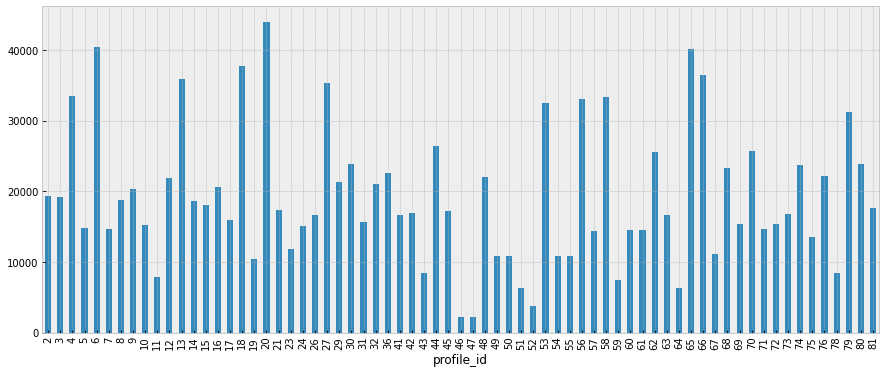

In [6]:
#plotando o tamanho de cada medição
plt.figure(figsize=(15,6))
df.groupby('profile_id')['pm'].agg('count').plot(kind = 'bar')





C:\Users\edann\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\edann\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\edann\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

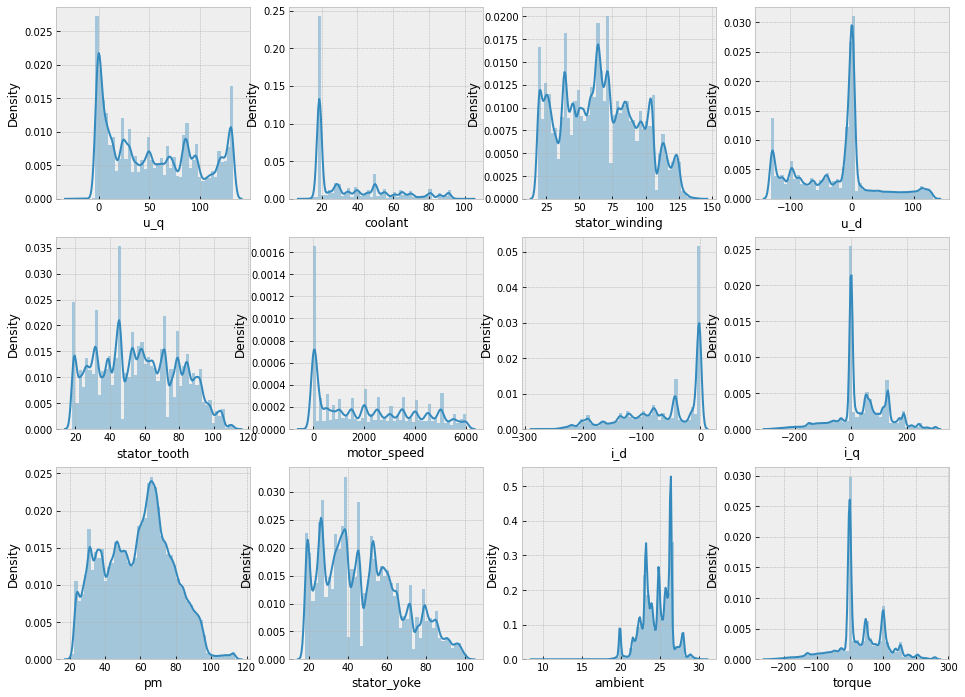

In [7]:
df_sem_id = df.drop(['profile_id'], axis=1) #tira a coluna id_profile
plt.figure(figsize=(16, 12))
for i in range(len(df_sem_id.columns)):
    plt.subplot(3, 4, i + 1)
    sns.distplot(df_sem_id[df_sem_id.columns[i]])
plt.show()

C:\Users\edann\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\edann\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\edann\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will re

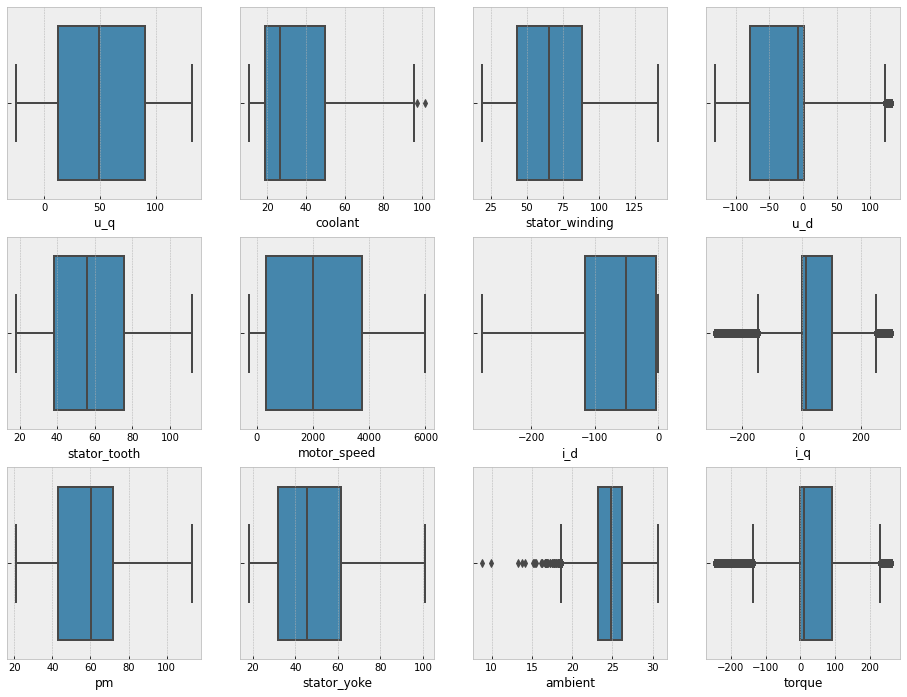

In [8]:
# boxplots e histogramas de todas as variáveis
plt.figure(figsize=(16, 12))
for i in range(len(df_sem_id.columns)):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(df_sem_id[df_sem_id.columns[i]])
plt.show()






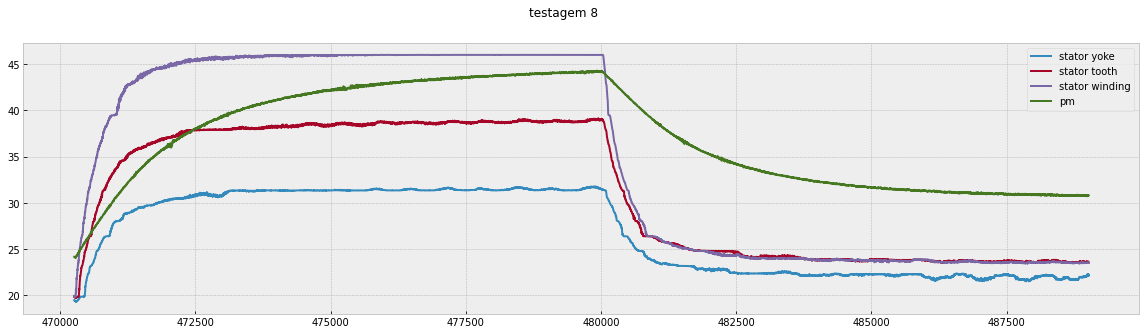

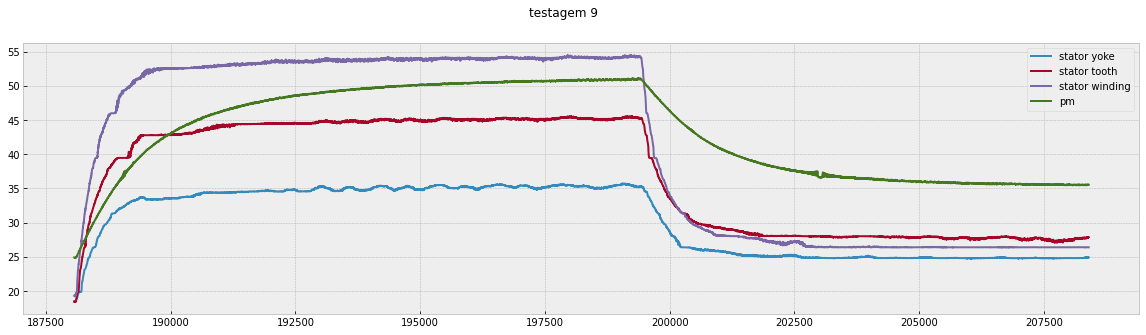

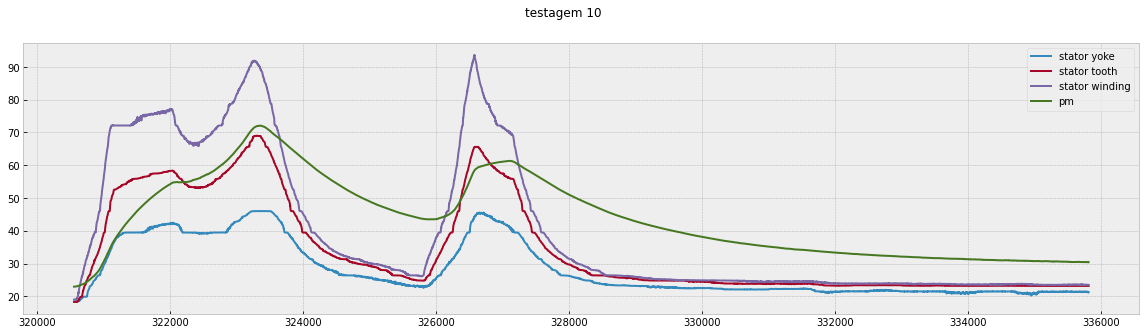

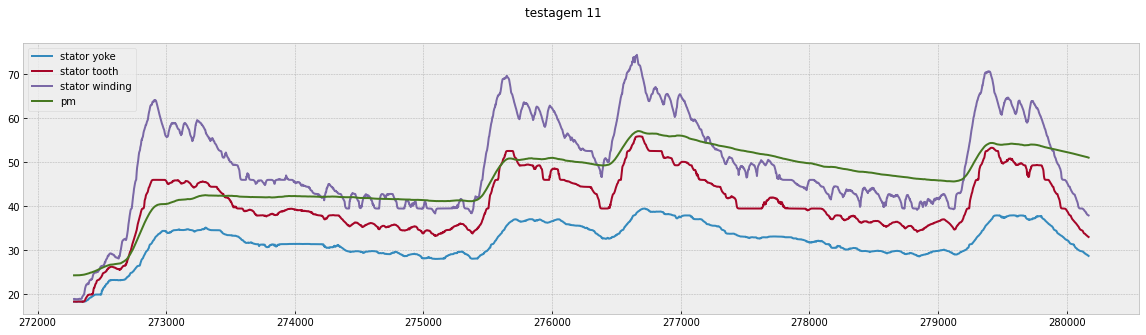

In [9]:
#plotagem dos valores das variáveis de saída de algumas realizações do teste
# como foram feitos 81 testagens, apenas uma amostra é apresentada visualmente

# visualmente se observa que a temperatura da parte magnética do estator (stator yoke), do dente do estator (stator tooth) e o enrolamento do estator (stator winding) se comportam de maneira proporcional, mas com intensidades diferentes
#já a variável da temperatura do rotor tem um comportamento diferente, com sua temperatura demorando mais a variar


for i in range(8, 12):
    plt.figure(figsize=(20,5))
    df[df['profile_id'] == i]['stator_yoke'].plot(label = 'stator yoke')
    df[df['profile_id'] == i]['stator_tooth'].plot(label = 'stator tooth')
    df[df['profile_id'] == i]['stator_winding'].plot(label = 'stator winding')
    df[df['profile_id'] == i]['pm'].plot(label = 'pm')
    plt.suptitle(f'testagem {i}')    
    plt.legend()

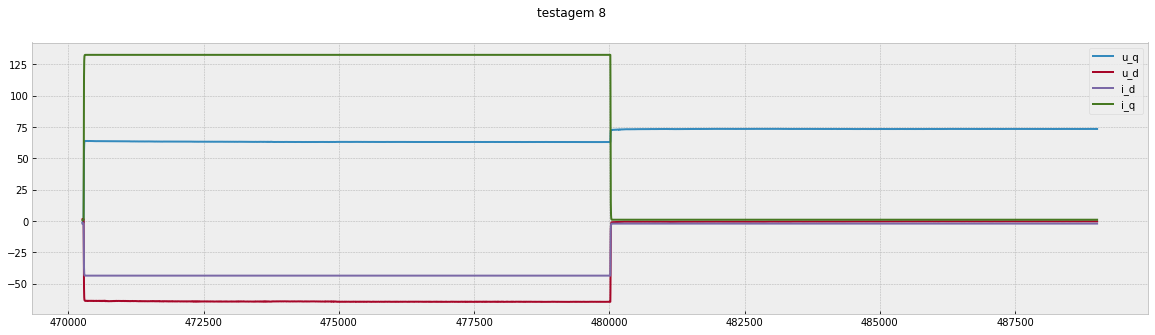

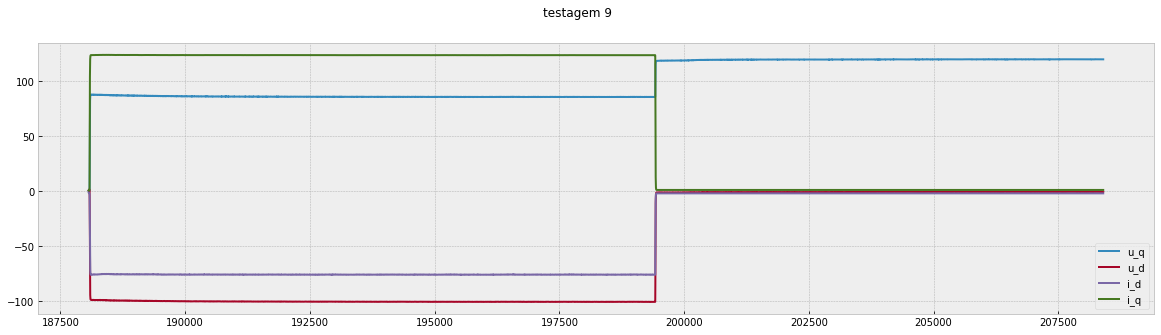

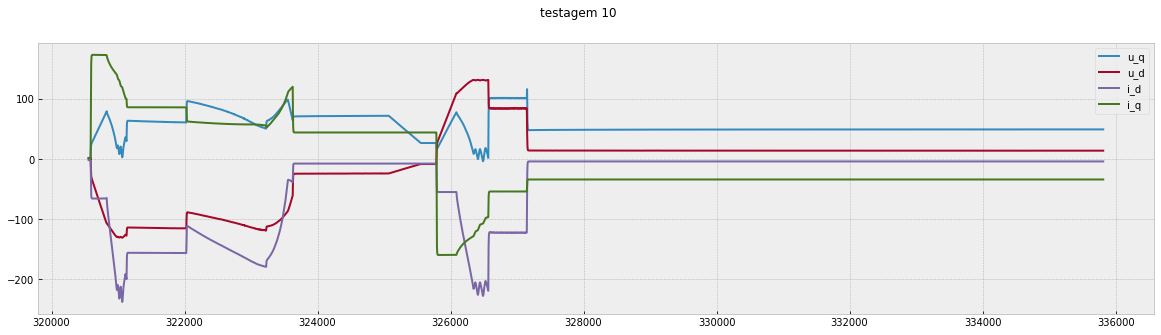

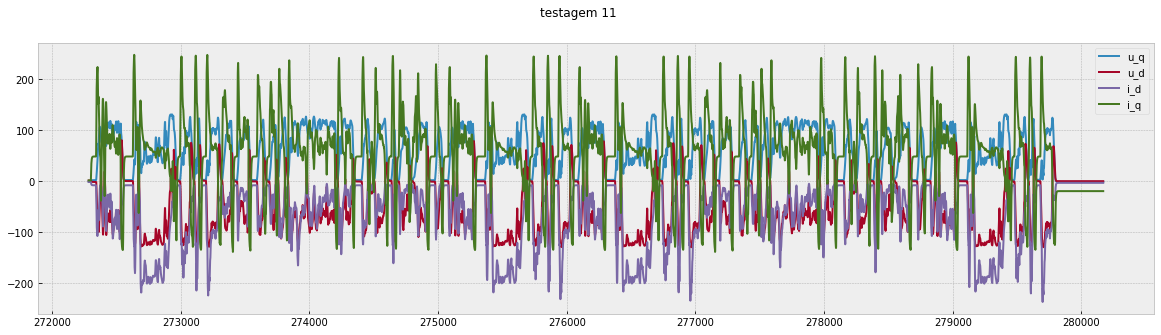

In [10]:
#plotagem dos valores das variáveis de entrada (voltagem, corrente) de algumas realizações do teste
for i in range(8, 12):
    plt.figure(figsize=(20,5))
    df[df['profile_id'] == i]['u_q'].plot(label = 'u_q')

    df[df['profile_id'] == i]['u_d'].plot(label = 'u_d')
    df[df['profile_id'] == i]['i_d'].plot(label = 'i_d')
    df[df['profile_id'] == i]['i_q'].plot(label = 'i_q')


    plt.suptitle(f'testagem {i}')    
    plt.legend()

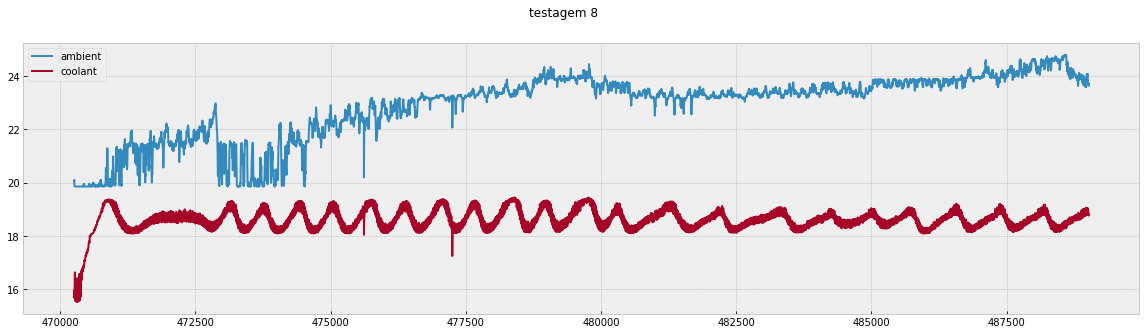

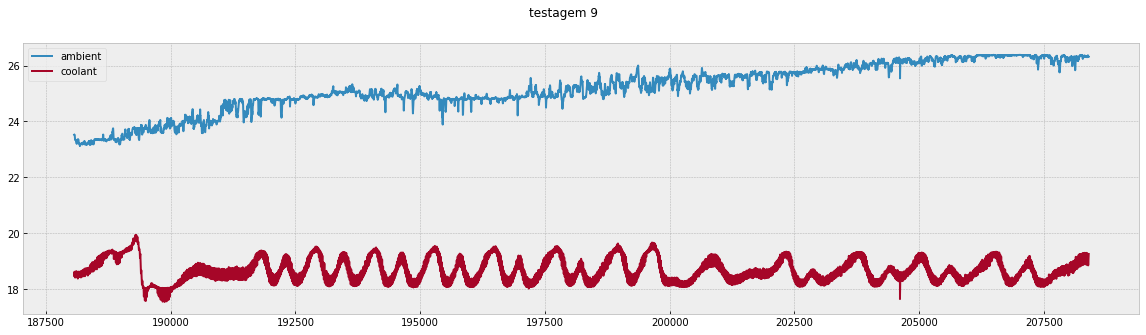

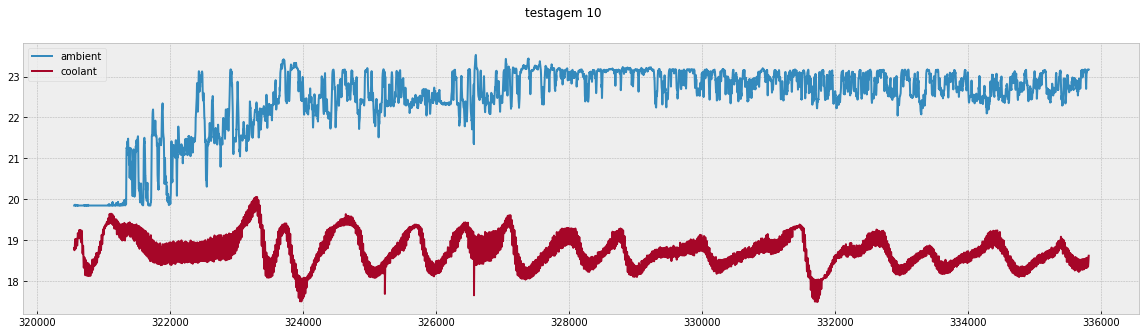

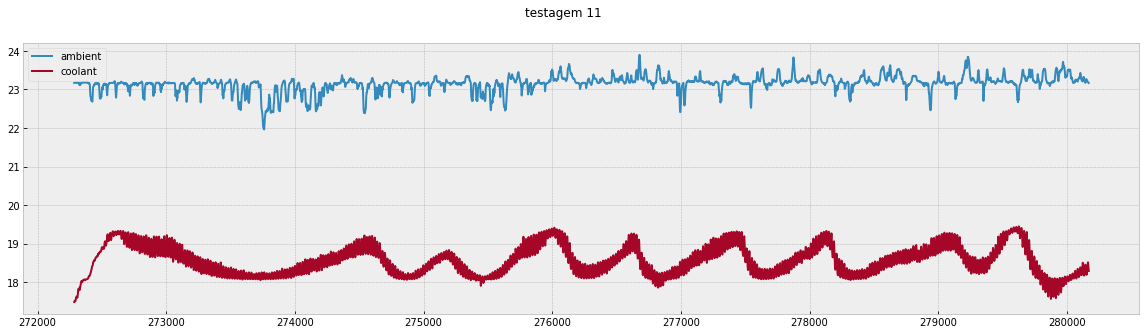

In [11]:
#variáveis de entrada da temperatura do liquido de arrefecimento e temperatura ambiente
for i in range(8, 12):
    plt.figure(figsize=(20,5))
    df[df['profile_id'] == i]['ambient'].plot(label = 'ambient')
    df[df['profile_id'] == i]['coolant'].plot(label = 'coolant')
    plt.suptitle(f'testagem {i}')    
    plt.legend()

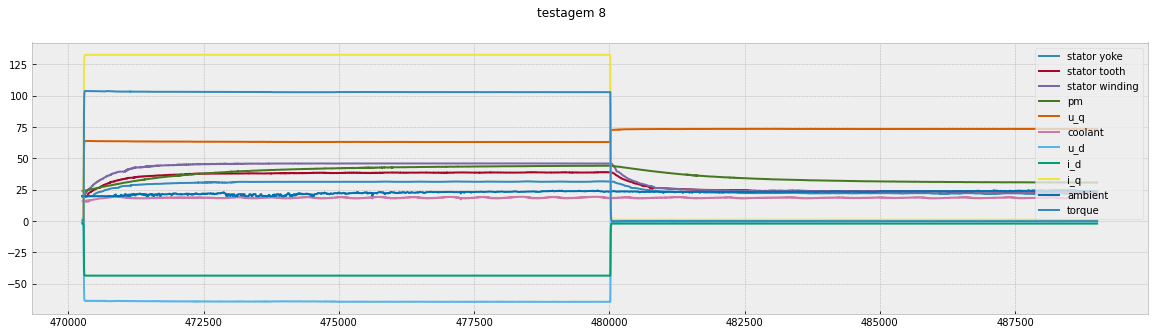

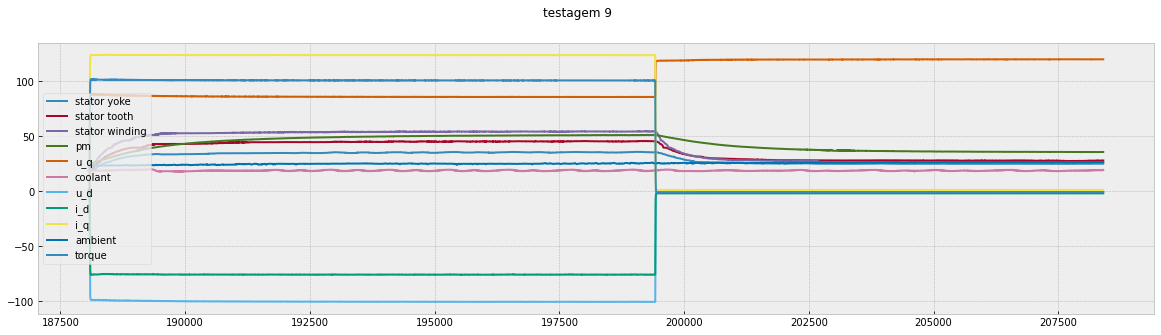

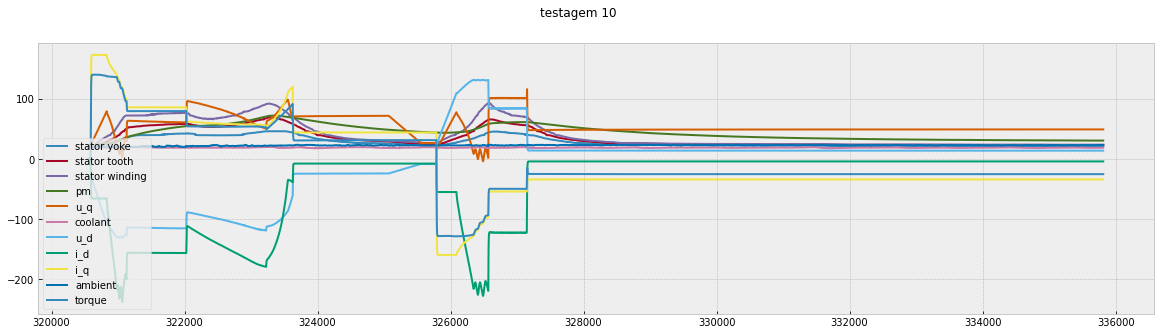

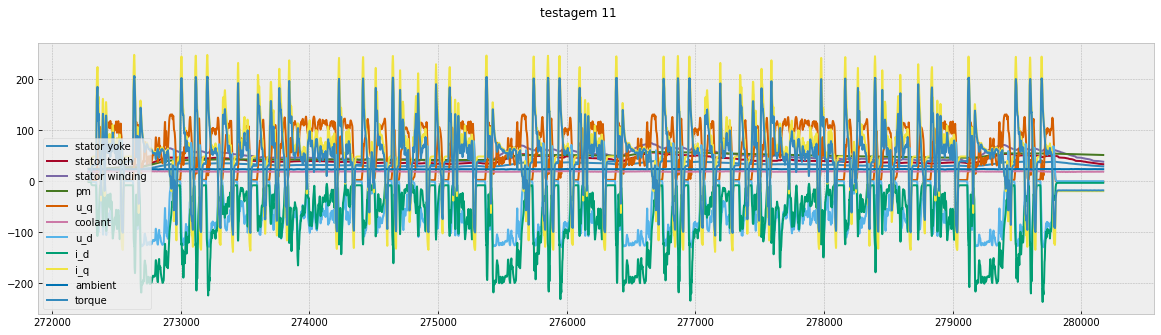

In [12]:
#variáveis de entrada e saídas juntas em algumas realizações do teste


# nos tres testes mostrados, é possível observar que assim que o motor é acionado e permanece constante, a temperatura começa a aumentar até alcançar uma certa estabilidade
#por outro lado, quando o motor é acionado e parado seguidas vezes, a temperatura alcança valores mais elevados
for i in range(8, 12):
    plt.figure(figsize=(20,5))
    df[df['profile_id'] == i]['stator_yoke'].plot(label = 'stator yoke')
    df[df['profile_id'] == i]['stator_tooth'].plot(label = 'stator tooth')
    df[df['profile_id'] == i]['stator_winding'].plot(label = 'stator winding')
    df[df['profile_id'] == i]['pm'].plot(label = 'pm')
    df[df['profile_id'] == i]['u_q'].plot(label = 'u_q')
    df[df['profile_id'] == i]['coolant'].plot(label = 'coolant')
    df[df['profile_id'] == i]['u_d'].plot(label = 'u_d')
    df[df['profile_id'] == i]['i_d'].plot(label = 'i_d')
    df[df['profile_id'] == i]['i_q'].plot(label = 'i_q')
    df[df['profile_id'] == i]['ambient'].plot(label = 'ambient')
    df[df['profile_id'] == i]['torque'].plot(label = 'torque')
    plt.suptitle(f'testagem {i}')    
    plt.legend()

In [13]:
"""teste de normalidade das variáveis de entrada e saída

Sendo variáveis de entrada (independentes):
u_d: Medição do componente d da voltagem em coordenadas-dq (em V);
u_q: Medição do componente q da voltagem em coordenadas-dq (em V);
i_d: Medição do componente d da corrente atual em coordenadas-dq;
i_q: Medição do componente q da corrente atual em coordenadas-dq
coolant: Temperatura do líquido de arrefecimento;
motor_speed: Velocidade do motor (em rpm);
ambient: Temperatura ambiente (em ºC);

Variável de saída (dependente):


"""

#funcao pra retornar os valores
def mostra_resultados(nome_variavel, shapiro_stat, shapiro_p_valor):
    print("\nvariável: ", nome_variavel)
    print("valor da estatística de Shapiro-Wilk = ", str(shapiro_stat))
    print("valor de p de Shapiro Wilk = ", str(shapiro_p_valor))
    if shapiro_p_valor > 0.05:
        print("Com 95% de confiança, os dados são similares a uma distribuição normal segundo o teste de Shapiro-Wilk")
    else:
        print("com 95% de confiança, os dados NÃO são similares a uma distribuição normal segundo o teste de Shapiro-Wilk")


#chamadas da função pra cada variável a ser testada
shapiro_stat, shapiro_p_valor = stats.shapiro(df['ambient'])
nome_variavel = "temperatura ambiente (ambient)"
mostra_resultados(nome_variavel, shapiro_stat, shapiro_p_valor)

shapiro_stat, shapiro_p_valor = stats.shapiro(df['coolant'])
nome_variavel = "temperatura do líquido de arrefecimento (coolant)"
mostra_resultados(nome_variavel, shapiro_stat, shapiro_p_valor)

shapiro_stat, shapiro_p_valor = stats.shapiro(df['u_d'])
nome_variavel = "voltagem - componente d (u_d)"
mostra_resultados(nome_variavel, shapiro_stat, shapiro_p_valor)

shapiro_stat, shapiro_p_valor = stats.shapiro(df['u_q'])
nome_variavel = "voltagem - componente q (u_q)"
mostra_resultados(nome_variavel, shapiro_stat, shapiro_p_valor)

shapiro_stat, shapiro_p_valor = stats.shapiro(df['motor_speed'])
nome_variavel = "velocidade do motor (motor_speed)"
mostra_resultados(nome_variavel, shapiro_stat, shapiro_p_valor)

shapiro_stat, shapiro_p_valor = stats.shapiro(df['i_d'])
nome_variavel = "corrende - componente d (i_d)"
mostra_resultados(nome_variavel, shapiro_stat, shapiro_p_valor)

shapiro_stat, shapiro_p_valor = stats.shapiro(df['i_q'])
nome_variavel = "corrente - componente q (i_q)"
mostra_resultados(nome_variavel, shapiro_stat, shapiro_p_valor)

shapiro_stat, shapiro_p_valor = stats.shapiro(df['pm'])
nome_variavel = "temperatura do rotor (pm)"
mostra_resultados(nome_variavel, shapiro_stat, shapiro_p_valor)



C:\Users\edann\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



variável:  temperatura ambiente (ambient)
valor da estatística de Shapiro-Wilk =  0.9644845128059387
valor de p de Shapiro Wilk =  0.0
com 95% de confiança, os dados NÃO são similares a uma distribuição normal segundo o teste de Shapiro-Wilk

variável:  temperatura do líquido de arrefecimento (coolant)
valor da estatística de Shapiro-Wilk =  0.8059797883033752
valor de p de Shapiro Wilk =  0.0
com 95% de confiança, os dados NÃO são similares a uma distribuição normal segundo o teste de Shapiro-Wilk

variável:  voltagem - componente d (u_d)
valor da estatística de Shapiro-Wilk =  0.9413362741470337
valor de p de Shapiro Wilk =  0.0
com 95% de confiança, os dados NÃO são similares a uma distribuição normal segundo o teste de Shapiro-Wilk

variável:  voltagem - componente q (u_q)
valor da estatística de Shapiro-Wilk =  0.9150587916374207
valor de p de Shapiro Wilk =  0.0
com 95% de confiança, os dados NÃO são similares a uma distribuição normal segundo o teste de Shapiro-Wilk

variável: 

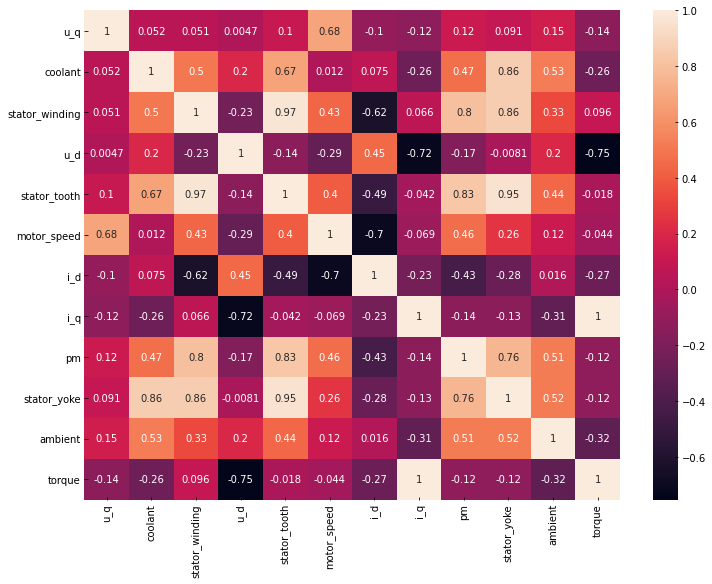

In [15]:
# matriz de correlações de pearson
fig = plt.figure(figsize=(12,9))
sns.heatmap(df_sem_id.corr(),annot=True)
plt.show()

<Figure size 360x360 with 0 Axes>

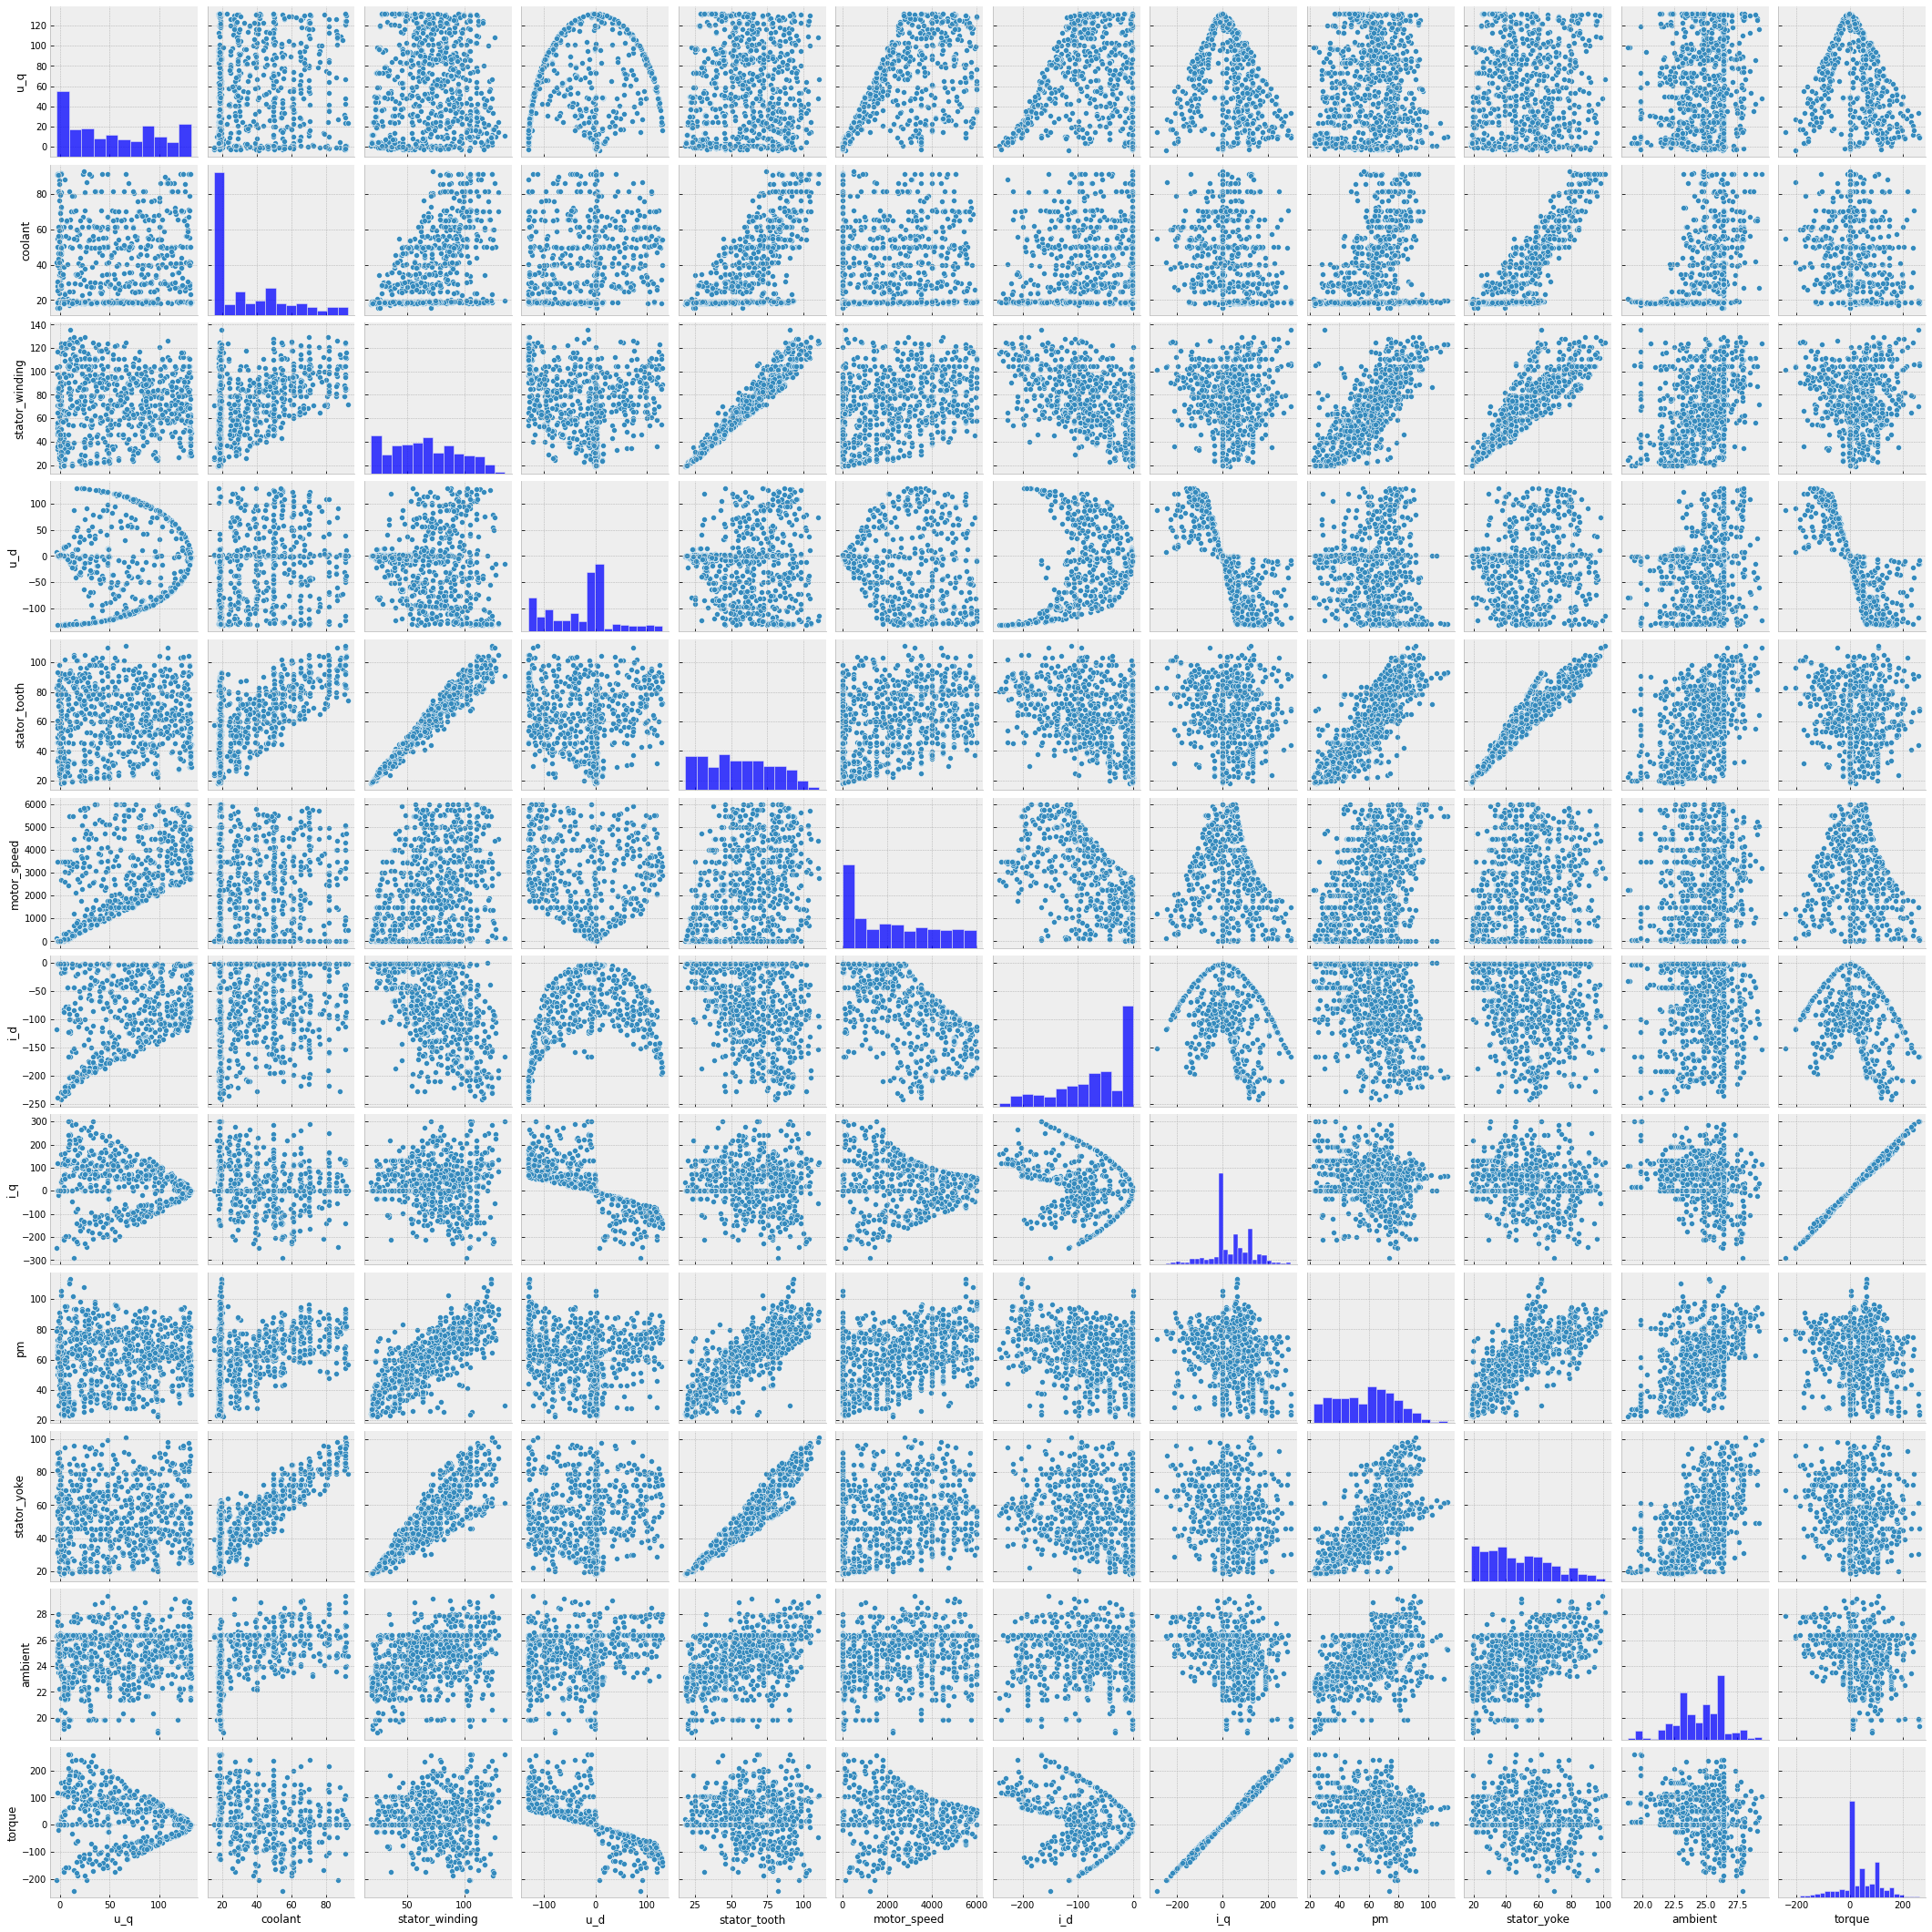

In [16]:
#plotagem de todas as dispersões entre as variáveis
plt.figure(figsize=(5, 5))
sns.pairplot(df_sem_id.sample(1000))
plt.show()

In [17]:
#correlação multipla entre as variáveis de entrada e a variavel dependente "pm" - temperatura do rotor

x = np.column_stack(( df['ambient'], df['coolant'],df['i_q'], df['u_q'], df['i_d'], df['u_d'], df['motor_speed']))
y = df['pm']


x2 = sm.add_constant(x)
model = sm.OLS(y, x2)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     pm   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                 2.881e+05
Date:                Sun, 04 Jul 2021   Prob (F-statistic):               0.00
Time:                        04:43:07   Log-Likelihood:            -5.1932e+06
No. Observations:             1330816   AIC:                         1.039e+07
Df Residuals:                 1330808   BIC:                         1.039e+07
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -39.7694      0.152   -261.383      0.0

Olhando para os valores de p de cada variável, todos eles parecem ser significativos e estão prevendo a temperatura  do rotor, pois os valores de p são muito baixos.




# Análise dos resultados da regressão múltipla

O R² mostra que o modelo calculado explica em 60,2% dos valores mensurados.
A variável mais influente é x1, que se refere à temperatura ambiente no momento da aferição, com coeficiente linear de 3,3598. A segunda variável mais influente dada pelo modelo é a de x2, que se refere à temperatura do líquido de arrefecimento, com coeficiente linear de 0,2719.

Olhando para os valores de p de cada variável, todos eles parecem ser significativos e estão prevendo a temperatura do rotor do estator, pois os valores de p são muito baixos.

A pontuação do teste Durbin-Watson também está muito próxima de 0, portanto, podemos dizer que há uma autocorrelação positiva no conjunto de dados.

O valor p para o teste de Jarque-Bera é menor que 0,05, então rejeitamos a hipótese nula de que os resíduos (variação natural dos dados que o modelo não capturou) são normalmente distribuídos. 

Também verificaremos a distribuição de resíduos, bem como QQ-plot para verificar visualmente.

<AxesSubplot:ylabel='Density'>

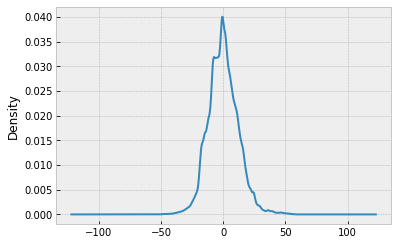

In [18]:
results.resid.plot(kind = 'density')

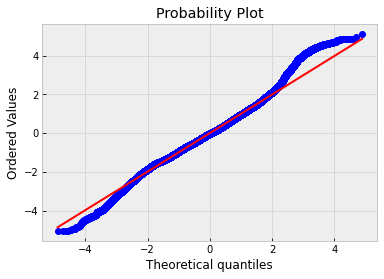

In [19]:
import scipy.stats as stats
import pylab
st_residual = results.get_influence().resid_studentized_internal
stats.probplot(st_residual, dist="norm", plot = pylab)
plt.show()

Como podemos ver no gráfico QQ, bem como no gráfico kde, os resíduos são baixos e distribuídos  ao redor do centro, mas se desviam da distribuição normal para os extremos, o que pode ser o fator que influencia o teste de JB e falhar no teste de normalidade.
